In [1]:
# work on the comparison of each privacy budget linked to the accuracy 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as ts

In [2]:
os.chdir("/Users/MauriceLubetzki/Documents/Etats-Unis/SAIL/HaoDeng/13063_2006_152_MOESM1_ESM")

In [3]:
df = pd.read_csv("Data-Table.csv")
df.head()

,id,age,sex,migraine,chronicity,acupuncturist,date_randomized,practice_id,group,pk1,...,p5cacu,p5all,p5dos,totalacu,totalother,totalgp,totalspec,totaldos,exposure,exposuredos
0,100,47,1,1,35,12,24/03/2000,35,1,10.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,101,52,1,1,8,12,24/03/2000,35,0,9.50,...,NaN,NaN,NaN,0.0,2.0,4.0,0.0,6.0,3.0,3.0
2,104,32,1,1,14,12,13/04/2000,35,0,16.00,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0
3,105,53,1,1,10,9,5/4/00,25,0,32.50,...,NaN,NaN,NaN,0.0,2.0,0.0,0.0,NaN,3.0,NaN
4,108,56,1,1,40,9,24/03/2000,25,0,16.50,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,23.0,12.0,12.0


In [4]:
def Sub_gradient(xi, yi,C,w,b): 
    if float(1- yi*(np.dot(xi.T, w)+b)) >0:
        comp_w =  w + C *(-yi * xi)
        comp_b =  C * (-yi)
    else:
        comp_w = w  
        comp_b = 0  
    return [comp_w,comp_b] 

In [5]:
def data_loader():
    Data=pd.read_csv("Data-Table.csv")
    Data =np.asarray(Data)
    Y=Data[:,3]
    X=Data[:,9:20]
    X =np.asarray(X,dtype=np.float64)
    X =np.nan_to_num(X)#Nan to Zeros

    X_Train=X[0:int(0.7*X.shape[0]),:]
    Y_Train = Y[0:int(0.7 * Y.shape[0])]

    X_Test = X[int(0.7 * X.shape[0]):X.shape[0], :]
    Y_Test = Y[int(0.7 * Y.shape[0]):X.shape[0]]

    return(X_Train,Y_Train,X_Test,Y_Test)

In [6]:
def get_DP_SVM(x_train,y_train,epsilon,C,L,coef_init=None,intercept_init=None,epochs = 100,learning_rate = 0.01, delta = 10**-3):
  # Initialize weights, epochs, learning rate
    if coef_init is None:
        w = np.random.uniform(size=(x_train.shape[1],))
        b= np.random.uniform(size=(1,))
    else:
        w=coef_init
        b=intercept_init

    epochs = epochs 

    y_train=np.asarray(y_train)
    y_train[y_train==0]=-1#SVM do 0 and 1
    y_train[y_train> 1]=-1
    #DP gradient descent 
    
    for epoch in range(0, epochs):
        randomize = np.arange(len(x_train))
        np.random.shuffle(randomize)
        randomize = randomize[0:L]
        x = x_train[randomize]
        y = y_train[randomize]
        Grad = [[],[]]
        Noise_w = np.random.normal(0,np.sqrt((2*np.log(1.25/delta)/epsilon**2)),11)
        Noise_b = np.random.normal(0,np.sqrt((2*np.log(1.25/delta)/epsilon**2)),1)
        
        #To have a differentially private SVM, we add some noise to each step of the SGD that 
        #we sample before updating the epoch.
        for xi, yi in zip(x, y):
            Grad[0].append([Sub_gradient(xi, yi,C,w,b)[0]])
            Grad[1].append([Sub_gradient(xi, yi,C,w,b)[1]])
           
        Grad_w = (np.sum(Grad[0],axis = 0 ) + Noise_w)/len(x)
        Grad_b = (np.sum(Grad[1],axis = 0 ) + Noise_b)/len(x)
        
        w = w - (learning_rate)*Grad_w
        w = w[0]
        b = b - (learning_rate)*Grad_b 
        b = b[0]
        
        
    return w,b

In [7]:
def get_SVM(x_train,y_train,C,coef_init=None,intercept_init=None,epochs = 100,learning_rate = 0.01):
  # Initialize weights, epochs, learning rate
    if coef_init is None:
        w = np.random.uniform(size=(x_train.shape[1],))
        b= np.random.uniform(size=(1,))
    else:
        w=coef_init
        b=intercept_init

    epochs = epochs 

    y_train=np.asarray(y_train)
    y_train[y_train==0]=-1#SVM do 0 and 1
    y_train[y_train> 1]=-1 # Maybe some two in the migrain data set, unsure data 2 

    # Stochastic Gradient Descent with hinge loss
    for epoch in range(0, epochs):
        randomize = np.arange(len(x_train))
        np.random.shuffle(randomize)
        x = x_train[randomize]
        y = y_train[randomize]
        loss = 0
        for xi, yi in zip(x, y):
            loss += max(0, 1 - yi * (np.dot(xi, w)+b))
        if (1-yi * (np.dot(xi, w)+b) >0 ): #or loss function > 0 
            # grad+=-yi*xi
            w =  (1-learning_rate)* w - learning_rate * C *(-yi * xi)
            b =  b - learning_rate * C * (-yi)
        else:
            # grad+=0
            w = (1-learning_rate)*w  
            b =  b  
    
    return w,b,loss

In [8]:
def F1_score(Predict,Y_Test):
    P = np.sum(Predict[Y_Test==1] == Y_Test[Y_Test==1]) / (np.sum(Predict[Y_Test==1] == Y_Test[Y_Test==1]) +\
                                                     np.sum(Predict[Y_Test == 0])) # False positive
    R = np.sum(Predict[Y_Test==1] == Y_Test[Y_Test==1]) / (np.sum(Predict[Y_Test==1] == Y_Test[Y_Test==1]) +\
                                                     np.sum(Y_Test[Predict==0])) # False negative
    
    return((2*P*R)/(P+R))

In [13]:
def SVMpredict(x,w,b):
    Output=np.sign(np.dot(x, w)+b)
    Output[Output==-1]=0#convert the predict from +1/-1 to 1/0
    Output[Output == 1]=1
    return(Output)

if __name__ == "__main__":
    X_Train, Y_Train, X_Test, Y_Test=data_loader()

    w, b, loss=get_SVM(X_Train, Y_Train, C = 1)
    
    w_DP,b_DP= get_DP_SVM(X_Train, Y_Train,epsilon = 1,C = 1,L = 130)

    Predict=SVMpredict(X_Test,w, b)
    
    Predict_DP = SVMpredict(X_Test,w_DP,b_DP)
    
    

    print( "F1 score " + str(F1_score(Predict,Y_Test)) + " No Differential Privacy")
    print("F1 score " + str(F1_score(Predict_DP,Y_Test)) + " With Differential Privacy")

F1 score 0.9789029535864979 No Differential Privacy
F1 score 0.3404255319148936 With Differential Privacy


In [12]:
Y_Test == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


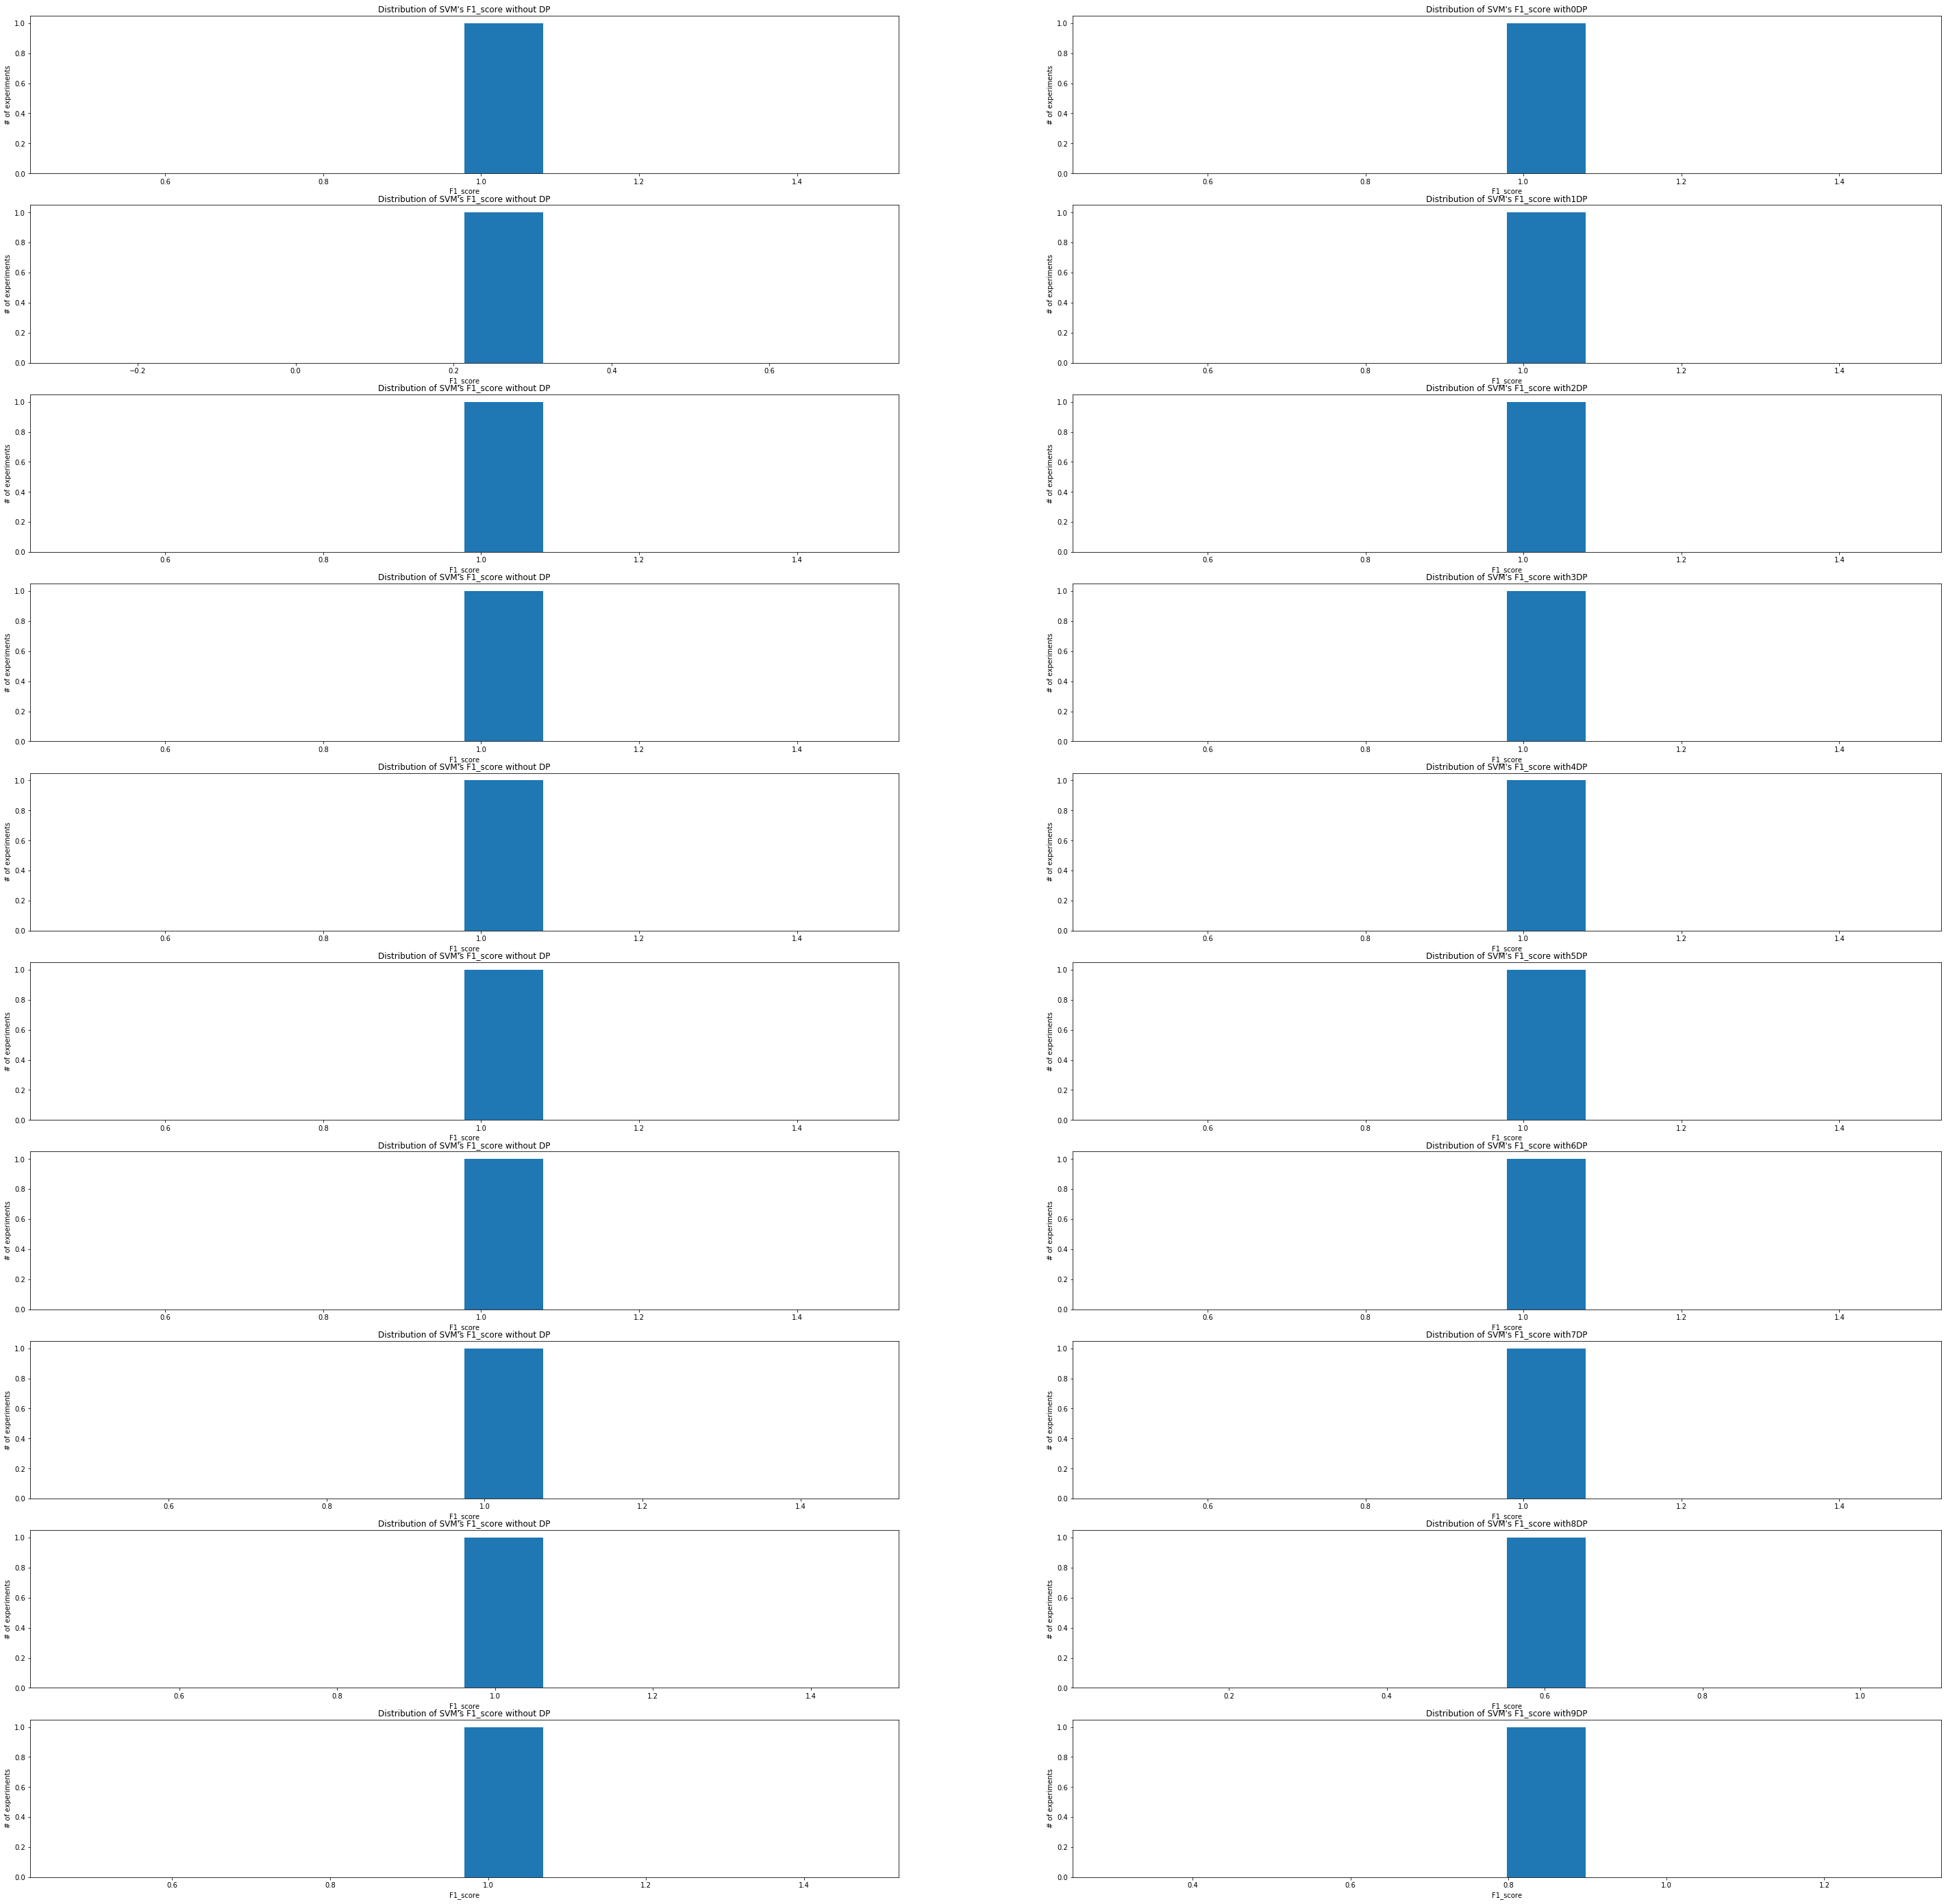

In [16]:
#Those results are way to homogenous. We don't have enough data to test the DP_SVM versus SVM 
B = np.linspace(1,0.01,10)

fig = plt.figure(figsize =(50,50))
k = 0 

for i in range(len(B)):
    
    X_Train, Y_Train, X_Test, Y_Test=data_loader()
    
    for j in range(0,100): 
        
        L , L_DP = [] , []
        
        w, b, loss = get_SVM(X_Train, Y_Train,C = 1)
        w_DP ,b_DP = get_DP_SVM(X_Train, Y_Train,epsilon = B[i],C = 1, L= 25)

        Predict = SVMpredict(X_Test,w, b)
        Predict_DP = SVMpredict(X_Test,w_DP,b_DP)

        L.append(F1_score(Predict,Y_Test))
        L_DP.append(F1_score(Predict_DP,Y_Test))
        
    fig.add_subplot(10,2,k+1)
    plt.hist(L)
    plt.title("Distribution of SVM's F1_score without DP")
    plt.xlabel('F1_score')
    plt.ylabel('# of experiments')
    fig.add_subplot(10,2,k+2)
    plt.hist(L_DP)
    plt.title("Distribution of SVM's F1_score with" + str(i) + "DP")
    plt.xlabel('F1_score')
    plt.ylabel('# of experiments')
    
    k+=2

fig = plt.figure(figsize =(10,5))
fig.add_subplot(1,2,1)
plt.hist(L)
plt.title("Distribution of SVM's F1_score without DP")
plt.xlabel('F1_score')
plt.ylabel('# of experiments')
fig.add_subplot(1,2,2)
plt.hist(L_DP)
plt.title("Distribution of SVM's F1_score with DP")
plt.xlabel('F1_score')
plt.ylabel('# of experiments')

In [17]:
B

array([1.  , 0.89, 0.78, 0.67, 0.56, 0.45, 0.34, 0.23, 0.12, 0.01])

Text(0.5, 1.0, "BoxPlot of SVM's F1_score with DP")

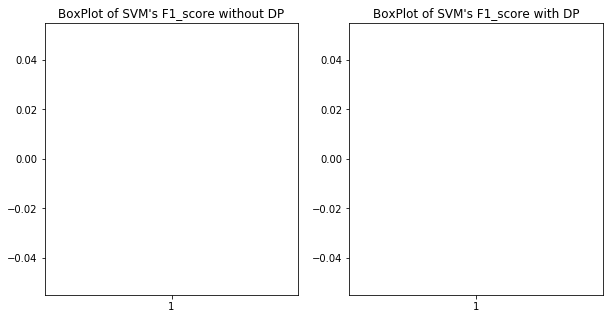

In [13]:
fig = plt.figure(figsize =(10,5))
fig.add_subplot(1,2,1)
plt.boxplot(L)
plt.title("BoxPlot of SVM's F1_score without DP")
fig.add_subplot(1,2,2)
plt.boxplot(L_DP)
plt.title("BoxPlot of SVM's F1_score with DP")

Text(0, 0.5, 'F1_score')

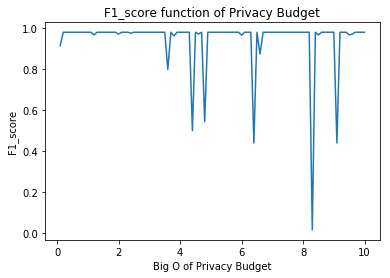

In [41]:
plt.plot(B.dot(np.sqrt(100)),L_DP)
plt.title('F1_score function of Privacy Budget')
plt.xlabel('Big O of Privacy Budget')
plt.ylabel('F1_score')

Need to compute an optimal C, thus we use Cross Validation on SVM 

In [42]:
def data_loader_CV():
    Data=pd.read_csv("Data-Table.csv")
    Data =np.asarray(Data)
    Y=Data[:,3]
    X=Data[:,9:20]
    X =np.asarray(X,dtype=np.float64)
    X =np.nan_to_num(X)#Nan to Zeros

    X_Train_CV = X[0:int(0.7*0.7*X.shape[0]),:]
    Y_Train_CV = Y[0:int(0.7*0.7* Y.shape[0])]
    
    X_Test_CV = X[int(0.7*0.7*X.shape[0]):int(0.7*X.shape[0]),:]
    Y_Test_CV = Y[int(0.7*0.7*Y.shape[0]):int(0.7*Y.shape[0])]

    return(X_Train_CV,Y_Train_CV,X_Test_CV,Y_Test_CV)

In [53]:
def SVM_CV(C): 
    X_Train_CV,Y_Train_CV,X_Test_CV,Y_Test_CV = data_loader_CV()
    L = []
    for i in range (len(C)):
        w, b, loss = get_SVM(X_Train_CV,Y_Train_CV,C[i])
        Predict=SVMpredict(X_Test_CV,w, b)
        L.append(1/len(Y_Test_CV)*sum([(Y_Test_CV[j]-Predict[j])**2 for j in range(0,len(Y_Test_CV))]))
    plt.plot(np.arange(len(C)),L,color ='r')
    print("optimal C is " + str(C[L.index(min(L))]))
    print("RSS is " + str(min(L)) ) 
    
def SVM_CV_DP(C,epsilon): 
    X_Train_CV,Y_Train_CV,X_Test_CV,Y_Test_CV = data_loader_CV()
    L = []
    for i in range (len(C)):
        w, b = get_DP_SVM(X_Train_CV,Y_Train_CV,epsilon,C[i],L=130)
        Predict=SVMpredict(X_Test_CV,w, b)
        print("Predict " + str(Predict))
        print("Y_test "+ str(Y_Test))
        print("C" + str(C[i]))
        L.append(1/len(Y_Test_CV)*sum([(Y_Test_CV[j]-Predict[j])**2 for j in range(0,len(Y_Test_CV))]))
        
    return [C[L.index(min(L))], min(L)]
    print("optimal C is " + str(C[L.index(min(L))]))
    print("RSS is " + str(min(L)))

optimal C is 9.899
RSS is 0.05952380952380952


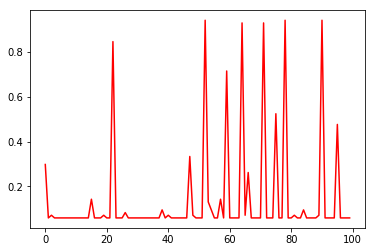

In [32]:
C = np.linspace(10,0.001,100)
SVM_CV(C)

In [34]:
#We don't haev enough data it's clear that we have an overfit. 
epsilon = np.linspace(1,0.01,20)
C = 10**(np.linspace(2,-2,40))
L = []
M = []
N = []
for i in epsilon:
    a = SVM_CV_DP(C,i)
    L.append(a[0])
    M.append(a[1])
    N.append(i)
    
d = {"Optimal C " : L, "RSS": M, "epsilon": N }
print(pd.DataFrame(data = d))

    Optimal C        RSS   epsilon
0   100.000000  0.059524  1.000000
1   100.000000  0.059524  0.947895
2    62.355073  0.059524  0.895789
3   100.000000  0.059524  0.843684
4   100.000000  0.059524  0.791579
5    78.965229  0.059524  0.739474
6   100.000000  0.059524  0.687368
7   100.000000  0.059524  0.635263
8   100.000000  0.059524  0.583158
9    78.965229  0.059524  0.531053
10  100.000000  0.059524  0.478947
11  100.000000  0.059524  0.426842
12  100.000000  0.059524  0.374737
13  100.000000  0.059524  0.322632
14  100.000000  0.059524  0.270526
15  100.000000  0.059524  0.218421
16   78.965229  0.059524  0.166316
17  100.000000  0.059524  0.114211
18  100.000000  0.059524  0.062105
19  100.000000  0.059524  0.010000
